In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img
from scipy import stats
%matplotlib inline

from sklearn.linear_model import (LogisticRegression, Lasso, LinearRegression)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
#READ IN PLAY BY PLAY
YEAR = 2021
YEAR2 = 2020

### Once Model is trained, will predict on this years data to evaluate RB's

In [4]:
#This year's continuously updating data
data = pd.read_csv(
    'https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_' \
    + str(YEAR) + '.csv.gz?raw=True',compression='gzip', low_memory=False)

### 2020 Data will be used to train the model

In [5]:
data2020 = pd.read_csv(
    'https://github.com/guga31bb/nflfastR-data/blob/master/data/play_by_play_' \
    + str(YEAR2) + '.csv.gz?raw=True',compression='gzip', low_memory=False)

### filter to JUST run plays and regular SZN

In [6]:
#data['season_type'].unique
data = data[(data['season_type'] == 'REG') & (data['play_type'] == 'run')]
data2020 = data2020[(data2020['season_type'] == 'REG') & (data2020['play_type'] == 'run')]

#### colors column for graphing purposes later on

In [7]:
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#125740','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

#mapping the color number to a NEW column called color, depending upon the posteam
data['color'] = data['posteam'].map(COLORS)
data2020['color'] = data2020['posteam'].map(COLORS)
data.shape
data2020.shape

(13412, 373)

### New DataFrame with the feature variables we'll use for the model

In [8]:
#Predicting EXPECTED rush yards
#This is designed runs only

both = data2020[['yardline_100', 'ydstogo', 'ep', 'down', 'wp', 'half_seconds_remaining', 'shotgun', 'yards_gained']]

In [51]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

clean_dataset(both)

#both.shape

,yardline_100,ydstogo,ep,down,wp,half_seconds_remaining,shotgun,yards_gained
3,55.0,10.0,2.768936,1.0,0.579976,1782.0,1.0,14.0
4,41.0,10.0,3.626150,1.0,0.604475,1739.0,0.0,2.0
5,39.0,8.0,3.171485,2.0,0.600411,1701.0,1.0,-6.0
23,64.0,5.0,1.876371,2.0,0.805080,1376.0,0.0,0.0
33,78.0,10.0,0.476620,1.0,0.407851,1217.0,1.0,2.0
...,...,...,...,...,...,...,...,...
46171,60.0,10.0,0.733928,3.0,0.942267,129.0,0.0,9.0
46174,45.0,10.0,2.496136,1.0,0.976550,120.0,0.0,5.0
46176,40.0,5.0,2.093218,2.0,0.973985,115.0,0.0,1.0
46178,39.0,4.0,0.864998,3.0,0.973690,109.0,0.0,3.0


## Creating the Linear Regression - predicting how many rushing yards should be gained per play
### Train Test Split on 2020 data

In [57]:
x = both[['yardline_100', 'ydstogo', 'ep', 'down', 'wp', 'half_seconds_remaining', 'shotgun']]
y = both['yards_gained']

In [11]:
reg = LinearRegression()
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = .3, random_state=43)

reg.fit(xtrain, ytrain)

y_pred = reg.predict(xtest) 

### DF of 2021 plays, where Reg will predict expected rush yards for each play

In [52]:
#Predicting expected rush yards on 2021 plays now
predictOn = data[['yardline_100', 'ydstogo', 'ep', 'down', 'wp', 'half_seconds_remaining', 'shotgun', 'yards_gained', 'rusher_player_id', 'play_id']]

#predictOn['rusher_player_id'].value_counts()


#Remove Characters From 'rusher_player_id' Column
predictOn['rusher_player_id'] = predictOn['rusher_player_id'].map(lambda x: str(x)[3:]) 
clean_dataset(predictOn)

,yardline_100,ydstogo,ep,down,wp,half_seconds_remaining,shotgun,yards_gained,rusher_player_id,play_id
2,75.0,10.0,1.474098,1.0,0.546262,1800.0,0.0,-3.0,32764.0,55.0
7,23.0,10.0,4.464375,1.0,0.616783,1675.0,1.0,2.0,35228.0,181.0
10,9.0,9.0,5.125393,1.0,0.630427,1600.0,1.0,0.0,34681.0,282.0
18,80.0,10.0,1.297861,1.0,0.432342,1457.0,0.0,-1.0,32764.0,473.0
28,75.0,10.0,1.518927,1.0,0.272925,1391.0,0.0,2.0,32764.0,716.0
...,...,...,...,...,...,...,...,...,...,...
48394,51.0,9.0,1.821026,2.0,0.998056,241.0,0.0,2.0,36755.0,3216.0
48396,49.0,7.0,1.235517,3.0,0.998099,235.0,1.0,11.0,31763.0,3254.0
48398,38.0,10.0,1.846072,1.0,0.998783,224.0,0.0,1.0,32975.0,3296.0
48399,37.0,9.0,1.201182,2.0,0.998763,178.0,1.0,0.0,32975.0,3317.0


In [13]:
this = predictOn[['yardline_100', 'ydstogo', 'ep', 'down', 'wp', 'half_seconds_remaining', 'shotgun']]
here = reg.predict(this)

In [53]:
predictOn['expected_rush_yards'] = here

In [15]:
predictOn

,yardline_100,ydstogo,ep,down,wp,half_seconds_remaining,shotgun,yards_gained,rusher_player_id,play_id,expected_rush_yards
2,75.0,10,1.474098,1.0,0.546262,1800.0,0,-3.0,0032764,55,5.079406
7,23.0,10,4.464375,1.0,0.616783,1675.0,1,2.0,0035228,181,4.407678
10,9.0,9,5.125393,1.0,0.630427,1600.0,1,0.0,0034681,282,3.958503
18,80.0,10,1.297861,1.0,0.432342,1457.0,0,-1.0,0032764,473,5.166839
28,75.0,10,1.518927,1.0,0.272925,1391.0,0,2.0,0032764,716,5.067510
...,...,...,...,...,...,...,...,...,...,...,...
48394,51.0,9,1.821026,2.0,0.998056,241.0,0,2.0,0036755,3216,4.643877
48396,49.0,7,1.235517,3.0,0.998099,235.0,1,11.0,0031763,3254,5.235873
48398,38.0,10,1.846072,1.0,0.998783,224.0,0,1.0,0032975,3296,4.229862
48399,37.0,9,1.201182,2.0,0.998763,178.0,1,0.0,0032975,3317,4.977329


In [16]:
rushers = (
    predictOn.groupby(['rusher_player_id'])
    .agg({'play_id':'count', 'yards_gained':'sum', 'expected_rush_yards':'sum'})
    .reset_index()
    .sort_values(by=['play_id'],ascending=False)
    .reset_index(drop=True)
    )
fullRushers = rushers[rushers['play_id'] >= 100]
fullRushers.head(3)

,rusher_player_id,play_id,yards_gained,expected_rush_yards
0,0036223,332,1811.0,1428.405822
1,0036893,307,1200.0,1471.982452
2,0033897,292,1205.0,1310.898650


In [17]:
#Checking rusher ID to the players name
data[data['rusher_player_id'] == '00-0035628']['rusher']

6586     D.Johnson
6587     D.Johnson
14528    D.Johnson
17621    D.Johnson
17622    D.Johnson
           ...    
46043    D.Johnson
46045    D.Johnson
46046    D.Johnson
46067    D.Johnson
46069    D.Johnson
Name: rusher, Length: 100, dtype: object

In [18]:
#Adding players name based off of rusher id
players = ['J.Taylor', 'N.Harris', 'J.Mixon', 'A.Gibson', 'D.Cook', 'A.Kamara', 'E.Elliot', 'N.Chubb', 'D.Montgomery', 'D.Henry', 'J.Jacobs', 'S.Michel', 
           'E.Mitchell', 'A.Ekeler', 'M.Gordon', 'Jav.Williams', 'D.Harris', 'J.Conner', 'D.Singletary', 'AJ.Dillon',
          'L.Fournette', 'M.Gaskin', 'C.Hubbard', 'A.Jones', 'J.Robinson', 'S.Barkley', 'M.Ingram', 'C.Patterson', 'Jam.Williams', 
          'D.Swift', 'D.Henderson', 'Mi.Carter', 'D.Booker', 'Dar.Williams', 'M.Davis', 'M.Sanders', 'A.Mattison', 'D.Foreman', 
          'R.Stevenson', 'D.Freeman', 'T.Pollard', 'J.Hurts', 'L.Jackson', 'R.Burkhead', 'L.Murray', 'C.Edwards-Helaire', 
          'R.Penny', 'C.Edmonds', 'J.Allen', 'A.Collins', 'K.Herbert', 'R.Jones', 'D.Johnson']

In [55]:
#NEW COLUMN, PLAYER NAMES
fullRushers['rusher'] = players

## Calculating RYOE (rush yards over expected)
### (Yards actually gained - model's expected rushing yards gained) per play

In [54]:
fullRushers['rushing_yards_over_expected'] = fullRushers['yards_gained'] - fullRushers['expected_rush_yards']
fullRushers = fullRushers.sort_values('rushing_yards_over_expected', ascending=False)
fullRushers

,rusher_player_id,play_id,yards_gained,expected_rush_yards,rusher,rushing_yards_over_expected,colors
0,0036223,332,1811.0,1428.405822,J.Taylor,382.594178,#003D79
48,0034857,110,778.0,502.973802,J.Allen,275.026198,#00338D
7,0034791,228,1259.0,1011.457752,N.Chubb,247.542248,#FB4F14
46,0034750,119,749.0,553.881287,R.Penny,195.118713,#7AC142
41,0036389,128,795.0,606.696900,J.Hurts,188.303100,#014A53
40,0035261,130,719.0,579.501096,T.Pollard,139.498904,#B0B7BC
42,0034796,127,772.0,646.788692,L.Jackson,125.211308,#241773
35,0035243,137,754.0,647.939755,M.Sanders,106.060245,#014A53
52,0035628,100,534.0,456.855918,D.Johnson,77.144082,#FB4F14
16,0035657,202,929.0,853.878039,D.Harris,75.121961,#0A2342


### Removing the 3 QB's 

In [21]:
noQB = fullRushers
noQB = noQB.drop(index=[48, 41, 42])
noQB.head(3)

,rusher_player_id,play_id,yards_gained,expected_rush_yards,rusher,rushing_yards_over_expected
0,0036223,332,1811.0,1428.405822,J.Taylor,382.594178
7,0034791,228,1259.0,1011.457752,N.Chubb,247.542248
46,0034750,119,749.0,553.881287,R.Penny,195.118713


In [22]:
#Adding team color corresponding to the rusher (for graphing purposes)
placeColor = ['#003D79', '#00338D', '#FB4F14', '#7AC142', '#014A53', '#B0B7BC', '#241773', '#014A53', '#FB4F14', '#0A2342', '#97233F', '#4F2E84', 
              '#D40909', '#0A2342', '#002147', '#24423C', '#00338D', '#C9243F', '#2072BA', '#002244', '#136677', 
             '#24423C', '#002244', '#4095D1', '#D40909', '#4095D1', '#125740', '#00143F', '#A08A58', '#A71930', 
              '#CA2430', '#002147', '#241773', '#B0B7BC', '#046EB4', '#CA2430', '#C4C9CC', '#4F2E84', '#7AC142', 
             '#192E6C', '#046EB4', '#FB4F14', '#A71930', '#0A2342', '#FFC20F', '#00143F', '#A08A58', '#97233F', 
             '#0085CA', '#C9243F', '#192E6C', '#0091A0', '#FFC20E']

fullRushers['colors'] = placeColor
fullRushers.head(3)

,rusher_player_id,play_id,yards_gained,expected_rush_yards,rusher,rushing_yards_over_expected,colors
0,0036223,332,1811.0,1428.405822,J.Taylor,382.594178,#003D79
48,0034857,110,778.0,502.973802,J.Allen,275.026198,#00338D
7,0034791,228,1259.0,1011.457752,N.Chubb,247.542248,#FB4F14


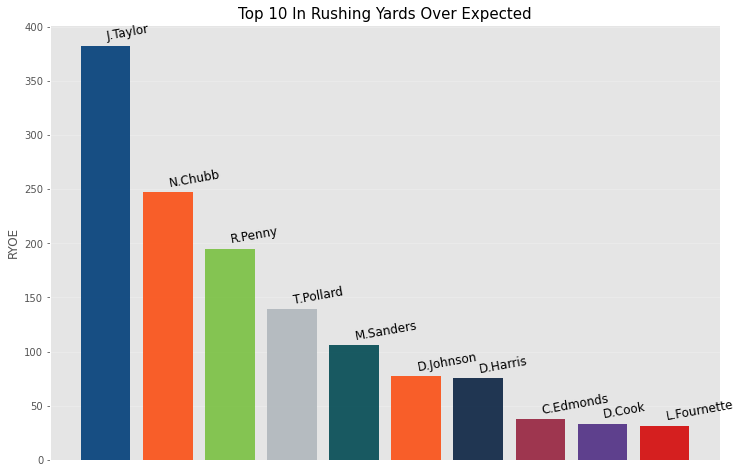

In [58]:
plt.figure(figsize=(12,8))
plt.bar(noQB['rusher'][:10], noQB['rushing_yards_over_expected'][:10], 
        color=['#003D79', '#FB4F14', '#7AC142', '#B0B7BC', '#014A53', '#FB4F14', '#0A2342', '#97233F', '#4F2E84', '#D40909'], 
       alpha=.9)
plt.title('Top 10 In Rushing Yards Over Expected', fontsize=15)

x = noQB['rusher'].values
y = noQB['rushing_yards_over_expected'].values

for i, label in enumerate(noQB.rusher):
    plt.annotate(label, (x[i], y[i] + 5), fontsize=12, rotation =10)
    
plt.xticks([''])
plt.ylabel('RYOE', fontsize=12)
plt.grid(True, alpha=.25)

plt.show()

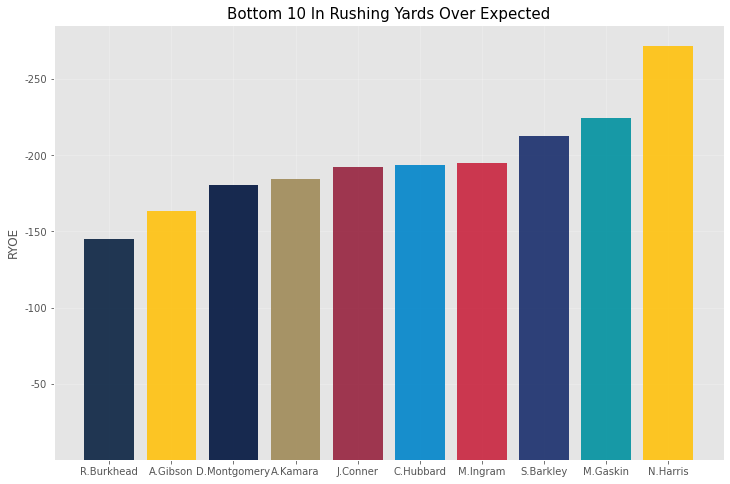

In [59]:
plt.figure(figsize=(12,8))
plt.bar(noQB['rusher'][-10:], noQB['rushing_yards_over_expected'][-10:] * -1, 
        color=['#0A2342', '#FFC20F', '#00143F', '#A08A58', '#97233F', '#0085CA', '#C9243F', '#192E6C', '#0091A0', '#FFC20E'], 
       alpha=.9)
plt.title('Bottom 10 In Rushing Yards Over Expected', fontsize=15)

testy = noQB['rusher'][-10:].values
yess = noQB['rushing_yards_over_expected'][-10:].values * -1

    
#plt.xticks([''])
plt.yticks([50,100,150,200,250],['-50', '-100', '-150', '-200', '-250'])
plt.ylabel('RYOE', fontsize=12)
plt.grid(True, alpha=.25)

plt.show()

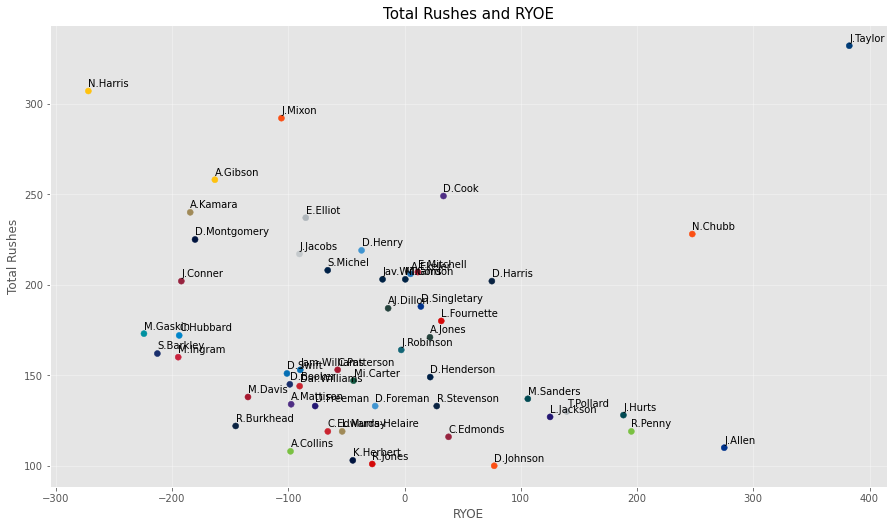

In [25]:
#Each teams most used RB
plt.style.use('ggplot')
plt.figure(figsize=(15,8.5))
plt.scatter(fullRushers['rushing_yards_over_expected'], fullRushers['play_id'], color=fullRushers['colors'])

exe = fullRushers['rushing_yards_over_expected'].values
why = fullRushers['play_id'].values

for i, label in enumerate(fullRushers.rusher):
    plt.annotate(label, (exe[i], why[i] + 2.5), fontsize=10)

plt.grid(True, alpha=.4)
plt.title('Total Rushes and RYOE', fontsize=15)
plt.ylabel('Total Rushes', fontsize=12)
plt.xlabel('RYOE', fontsize=12)
plt.show()

In [56]:
findEpa = (
    data.groupby(['rusher', 'color', 'posteam'])
    .agg({'play_id':'count', 'epa':'mean'})
    .reset_index()
    .sort_values(by=['play_id'],ascending=False)
    .reset_index(drop=True)
    )
findEpa = findEpa[findEpa['play_id'] >= 100]
findEpa['rusher'][14] = 'Jav.Williams'
findEpa['rusher'][32] = 'Dar.Williams'
findEpa

,rusher,color,posteam,play_id,epa
0,J.Taylor,#003D79,IND,332,0.103823
1,N.Harris,#FFC20E,PIT,307,-0.063137
2,J.Mixon,#FB4F14,CIN,294,-0.086508
3,A.Gibson,#FFC20F,WAS,259,-0.093163
4,D.Cook,#4F2E84,MIN,251,-0.038947
5,A.Kamara,#A08A58,NO,241,-0.169728
6,E.Elliott,#B0B7BC,DAL,240,-0.067122
7,N.Chubb,#FB4F14,CLE,228,0.046624
8,D.Montgomery,#00143F,CHI,224,-0.095185
9,D.Henry,#4095D1,TEN,220,-0.022010


In [60]:
merged = pd.merge(findEpa, noQB, left_on=['rusher'], right_on=['rusher'], how='inner')
merged.head(3)

,rusher,color,posteam,play_id_x,epa,rusher_player_id,play_id_y,yards_gained,expected_rush_yards,rushing_yards_over_expected
0,J.Taylor,#003D79,IND,332,0.103823,0036223,332,1811.0,1428.405822,382.594178
1,N.Harris,#FFC20E,PIT,307,-0.063137,0036893,307,1200.0,1471.982452,-271.982452
2,J.Mixon,#FB4F14,CIN,294,-0.086508,0033897,292,1205.0,1310.898650,-105.898650


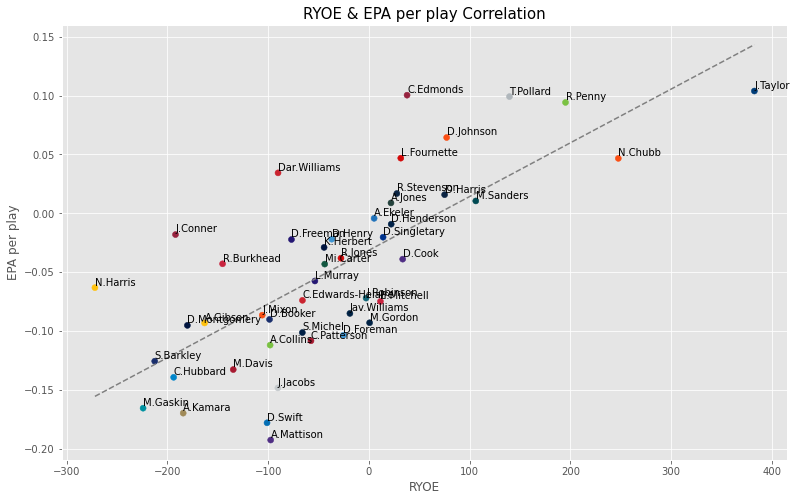

In [61]:
plt.figure(figsize=(13,8))
plt.scatter(merged['rushing_yards_over_expected'], merged['epa'], c = merged['color'])
plt.xlabel('RYOE')
plt.ylabel('EPA per play')
plt.title('RYOE & EPA per play Correlation', fontsize=15)

plt.plot(np.unique(merged['rushing_yards_over_expected']), np.poly1d(np.polyfit(merged['rushing_yards_over_expected'], merged['epa'], 1))(np.unique(merged['rushing_yards_over_expected'])), 
         color='grey', linestyle='--')


x = merged['rushing_yards_over_expected'].values
y = merged['epa'].values
for i, label in enumerate(merged.rusher):
    plt.annotate(label, (x[i], y[i] + .002), fontsize=10)

plt.show()

# Clear Positive Correlation between the RYOE model and the universal way of grading players by EPA per play